# Подготовили студенты ИУ10-95, Яроц И.В., Ульшин И.А.

О датасете: \
Набор данных состоит из круглых снимков примерно из 700 демонстраций турниров высокого уровня в 2019 и 2020 годах. Раунды разминки и перезапуски были отфильтрованы, а для оставшихся живых раундов снимок раундов записывался каждые 20 секунд до тех пор, пока раунд не был решен. После первоначальной публикации он был предварительно обработан и сглажен, чтобы улучшить читаемость и упростить обработку алгоритмов. Общее количество снимков составляет 122411. Снимки являются i.i.d и должны рассматриваться как отдельные точки данных, а не как часть совпадения.
https://www.kaggle.com/christianlillelund/csgo-round-winner-classification

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [2]:
#Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
#Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('csgo_round_snapshots.csv')

### Предобработка

In [4]:
c = df.columns
df.drop([c[22], c[30], c[37], c[52], c[58], c[60]], axis = 1, inplace = True)   #удалили поля с неиспользуемым оружием в игре (в лабе 1 и 2 более подробно про предобработку данных расписано) 
# Дальше преобразуем категориальные (2) и булевые (1) данные в числовые для парочки полей (тк значения в признаках отличаются сильно использовать OneHotEncoding не вижу смысла):
encoder = preprocessing.LabelEncoder()
df['map'] = encoder.fit_transform(df['map'])
df['round_winner'] = encoder.fit_transform(df['round_winner'])
df['bomb_planted'] = encoder.fit_transform(df['bomb_planted'])
y = df['round_winner'] # целевая переменная
X = df.drop('round_winner', axis = 1) # признаки

In [5]:
X.shape, y.shape

((122410, 90), (122410,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [7]:
first_tree = DecisionTreeClassifier(random_state=17)

In [8]:
first_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=17)

In [9]:
y_pred =  first_tree.predict(X_test)
print('Точность измерений (тестовые данные): ', accuracy_score(y_true = y_test, y_pred = y_pred))

Точность измерений (тестовые данные):  0.8161370258421153


In [10]:
cross_val_score(first_tree, X_train, y_train, cv=5)
# 5 раз дерево обучилось на наших данных

array([0.80680359, 0.79525032, 0.79984828, 0.79903134, 0.79768921])

In [11]:
# возьмем среднее от них (по сути, это среднее качество на кросс-валидации)
np.mean(cross_val_score(first_tree, X_train, y_train, cv=5))

0.7997245485917572

### без кросс валидации дерево решений показывает оценку лучше

Данный алгоритм показал, неплохую оценку, но важно помнить, что его минус в переобучаемости на тренировочных данных. Если не задать ему определенную глубину дерева, то оценка существенно упадет, когда мы пройдемся по тестовой выборке.

## Случайный лес

In [12]:
# Инициализируем стратифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Инициализируем наш классификатор с дефолтными параметрами
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

In [13]:
rfc.fit(X_train,y_train)

y_pred = rfc.predict(X_test)

from sklearn import metrics
print("Accuracy score: {:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))

Accuracy score: 87.29%


In [14]:
# Обучаем на тренировочном датасете
results = cross_val_score(rfc, X, y, cv=skf)

# Оцениваем точность на тестовом датасете с помощью кросс валидации
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 87.89%


Получили везде точность примерно 87%

Достанем самые значимые признаки:

In [15]:
rfc.feature_importances_

array([4.24958280e-02, 3.25045724e-02, 3.28536075e-02, 2.89487374e-02,
       9.76471470e-03, 3.02546371e-02, 3.34115567e-02, 7.04757471e-02,
       8.27024520e-02, 5.45654931e-02, 5.50023152e-02, 3.37844578e-02,
       3.53913520e-02, 3.37159029e-02, 1.93500874e-02, 1.87980535e-02,
       8.43947789e-03, 2.58954858e-02, 5.58210735e-03, 6.06113422e-04,
       1.29043007e-02, 8.36815548e-03, 5.54291837e-06, 5.85162109e-03,
       3.88879311e-03, 7.11267414e-04, 1.87947298e-04, 4.39471623e-03,
       2.23319956e-04, 5.07709817e-05, 7.44278558e-04, 4.33443761e-03,
       8.29304503e-04, 2.04358046e-02, 0.00000000e+00, 3.66934557e-03,
       2.25136434e-04, 2.00796242e-02, 2.62788597e-03, 5.72679230e-04,
       3.67628943e-03, 4.55162715e-04, 4.17426388e-08, 1.23118781e-04,
       1.66381204e-04, 2.88131545e-04, 2.31812530e-04, 5.14758647e-03,
       2.92147302e-04, 7.80631218e-07, 1.53584559e-04, 1.76311528e-05,
       7.12316709e-06, 2.04894026e-05, 5.81040979e-07, 1.67978344e-05,
      

In [16]:
len(rfc.feature_importances_)

90

In [17]:
col = [i for i in range(90)]
listValues = rfc.feature_importances_
myDict = {col[i]:listValues[i] for i in range(0, len(col), 1)} 
for key in myDict:
    print(key, '->', myDict[key])

0 -> 0.04249582799363503
1 -> 0.03250457241468864
2 -> 0.03285360749688188
3 -> 0.02894873742453941
4 -> 0.0097647146967067
5 -> 0.03025463710165191
6 -> 0.033411556650724594
7 -> 0.07047574707813946
8 -> 0.08270245200416598
9 -> 0.05456549312958352
10 -> 0.0550023152307798
11 -> 0.03378445779071033
12 -> 0.03539135202011828
13 -> 0.03371590290479705
14 -> 0.01935008738476664
15 -> 0.018798053538518253
16 -> 0.008439477894869802
17 -> 0.025895485820466597
18 -> 0.005582107353316595
19 -> 0.0006061134222983432
20 -> 0.012904300734207676
21 -> 0.00836815548142242
22 -> 5.542918365430925e-06
23 -> 0.005851621086653912
24 -> 0.0038887931138659832
25 -> 0.0007112674137127898
26 -> 0.00018794729753449232
27 -> 0.004394716226957016
28 -> 0.0002233199563557956
29 -> 5.0770981675719274e-05
30 -> 0.000744278557550092
31 -> 0.004334437605536736
32 -> 0.0008293045030387022
33 -> 0.02043580462614753
34 -> 0.0
35 -> 0.0036693455712357883
36 -> 0.00022513643412486032
37 -> 0.020079624151011468
38 -> 

In [18]:
# если значения признака меньше 0.01 удалим его (считаем их близкими к нулю)
key_new = list()
for key in myDict:
    if myDict[key] < 0.01:
        key_new.append(key)
print(key_new) # номера столбцов которые мы будем удалять для метода ближайших соседей

[4, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 85, 86, 88, 89]


In [19]:
df1 = pd.read_csv('csgo_round_snapshots.csv')

In [20]:
c = df.columns

In [21]:
for i in key_new:
     df1.drop([c[i]], axis = 1, inplace = True)

In [22]:
df1.info()
#видим что некоторые поля не числовые

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 36 columns):
time_left                       122410 non-null float64
ct_score                        122410 non-null float64
t_score                         122410 non-null float64
map                             122410 non-null object
ct_health                       122410 non-null float64
t_health                        122410 non-null float64
ct_armor                        122410 non-null float64
t_armor                         122410 non-null float64
ct_money                        122410 non-null float64
t_money                         122410 non-null float64
ct_helmets                      122410 non-null float64
t_helmets                       122410 non-null float64
ct_defuse_kits                  122410 non-null float64
ct_players_alive                122410 non-null float64
t_players_alive                 122410 non-null float64
t_weapon_ak47                   122410 non-null fl

In [23]:
#преобразуем их
df1['round_winner'] = encoder.fit_transform(df['round_winner'])
df1['map'] = encoder.fit_transform(df['map'])

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 36 columns):
time_left                       122410 non-null float64
ct_score                        122410 non-null float64
t_score                         122410 non-null float64
map                             122410 non-null int64
ct_health                       122410 non-null float64
t_health                        122410 non-null float64
ct_armor                        122410 non-null float64
t_armor                         122410 non-null float64
ct_money                        122410 non-null float64
t_money                         122410 non-null float64
ct_helmets                      122410 non-null float64
t_helmets                       122410 non-null float64
ct_defuse_kits                  122410 non-null float64
ct_players_alive                122410 non-null float64
t_players_alive                 122410 non-null float64
t_weapon_ak47                   122410 non-null flo

Видим что в итоге наш алгоритм отобрал 36 значимых признаков, в отличии от 3 лабы, где мы получили 50. Но обратим внимание, что признак с названиями карт он посчитал как важный, и это действительно так. (в 3 лабораторной алгоритм счел его не самым значимым).

In [25]:
y = df1['round_winner'] # целевая переменная
X = df1.drop('round_winner', axis = 1) # признаки
X.shape, y.shape

((122410, 35), (122410,))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Теперь посмотрим, как ведут себя кривые обучения при изменении основных параметров.

Начнем с количества деревьев:

In [27]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

C:\Users\Igor\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Igor\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Igor\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Igor\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Igor\AppData\Roaming\Python\Python37\site-packages\sklearn\

C:\Users\Igor\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Igor\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Igor\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Igor\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Best accuracy on CV is 86.49% with 100 trees


Лучшая точность 86.49% на 100 деревьев

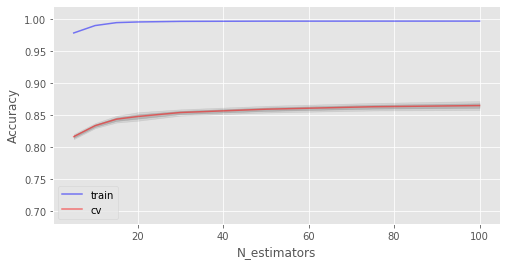

In [28]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.68,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

График оценки точности при разном количестве деревьев, + можно увидеть что на тренировочном наборе наше дерево переобучилось. Чтобы избежать переобучения, мы должны добавить параметры регуляризации в модель. Добавим в начале глубину:

Best accuracy on CV is 85.99% with 24 max_depth


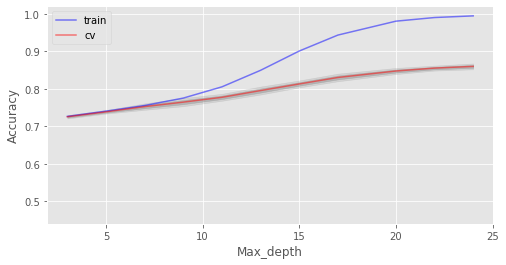

In [29]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.44,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth");

Параметр max_depth хорошо справляется с регуляризацией модели, и мы уже не так сильно переобучаемся. 

Еще важный параметр min_samples_leaf, он так же выполняет функцию регуляризатора.

In [30]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 86.49% with 1 min_samples_leaf


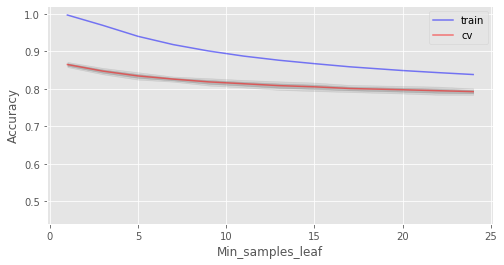

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.44,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf");

В данном случае мы не выигрываем в точности на валидации, но зато можем сильно уменьшить переобучение

Рассмотрим такой параметр как max_features. Для задач классификации по умолчанию используется $\large \sqrt{n}$, где n — число признаков. Давайте проверим, оптимально ли в нашем случае использовать 4 признаков или нет.

Best accuracy on CV is 87.42% with 16 max_features


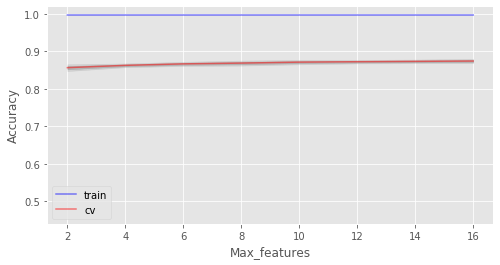

In [32]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.44,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features");

В нашем случае оптимальное число признаков — 10, именно с таким значением достигается наилучший результат.

Мы рассмотрели, как ведут себя кривые обучения в зависимости от изменения основных параметров.Сейчас с помощью GridSearch мы найдем оптимальные параметры для нашей задачи.

In [33]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 33.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [4, 7, 10, 13],
                         'min_samples_leaf': [1, 3, 5, 7]},
             verbose=1)

In [34]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(max_depth=20, max_features=13, n_jobs=-1, oob_score=True,
                        random_state=42), 0.8574626256024833)

Лучшая точность, который мы смогли достичь с помощью перебора параметров — 85.52% при: 'max_depth': 20, 'max_features': 13, 'min_samples_leaf': 1.

## Градиентный бустинг

In [35]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [36]:
%%time
from catboost import CatBoostRegressor
import numpy as np

scores = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 100, 10)):
    for j, depth in enumerate(np.arange(2, 12)):
        p = CatBoostRegressor(n_estimators=n_trees, max_depth=depth).fit(X_train, y_train).predict(X_test)
        scores[i, j] = mean_squared_error(y_test, p)

Learning rate set to 0.5
0:	learn: 0.4536786	total: 165ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4490379	total: 7.51ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4456305	total: 20.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4406272	total: 40.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4369181	total: 42.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4348929	total: 22.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4338463	total: 46.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4332708	total: 44.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4315077	total: 64.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4289325	total: 83.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4536786	total: 8.61ms	remaining: 94.7ms
1:	learn: 0.4342365	total: 17.4ms	remaining: 86.8ms
2:	learn: 0.4259401	total: 26.6ms	remaining: 79.8ms
3:	learn: 0.4210007	total: 35ms	remaining: 70.1ms
4:	learn: 0.4170769	total: 43.

Learning rate set to 0.5
0:	learn: 0.4490379	total: 8.48ms	remaining: 187ms
1:	learn: 0.4282706	total: 18ms	remaining: 189ms
2:	learn: 0.4187862	total: 26.6ms	remaining: 177ms
3:	learn: 0.4120285	total: 36.5ms	remaining: 173ms
4:	learn: 0.4090976	total: 46.8ms	remaining: 168ms
5:	learn: 0.4059821	total: 59.8ms	remaining: 170ms
6:	learn: 0.4041060	total: 71.6ms	remaining: 164ms
7:	learn: 0.4028920	total: 81.7ms	remaining: 153ms
8:	learn: 0.4022297	total: 93ms	remaining: 145ms
9:	learn: 0.4014843	total: 103ms	remaining: 134ms
10:	learn: 0.4004062	total: 115ms	remaining: 126ms
11:	learn: 0.3999268	total: 126ms	remaining: 115ms
12:	learn: 0.3992903	total: 139ms	remaining: 107ms
13:	learn: 0.3986654	total: 150ms	remaining: 96.3ms
14:	learn: 0.3982296	total: 162ms	remaining: 86.5ms
15:	learn: 0.3975723	total: 174ms	remaining: 76ms
16:	learn: 0.3972236	total: 185ms	remaining: 65.3ms
17:	learn: 0.3968055	total: 196ms	remaining: 54.4ms
18:	learn: 0.3965821	total: 207ms	remaining: 43.5ms
19:	lea

20:	learn: 0.3727125	total: 709ms	remaining: 67.5ms
21:	learn: 0.3714178	total: 743ms	remaining: 33.8ms
22:	learn: 0.3701672	total: 776ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4315077	total: 106ms	remaining: 2.34s
1:	learn: 0.4059410	total: 238ms	remaining: 2.5s
2:	learn: 0.3958666	total: 330ms	remaining: 2.2s
3:	learn: 0.3912229	total: 411ms	remaining: 1.95s
4:	learn: 0.3892836	total: 507ms	remaining: 1.82s
5:	learn: 0.3878787	total: 592ms	remaining: 1.68s
6:	learn: 0.3863143	total: 688ms	remaining: 1.57s
7:	learn: 0.3855814	total: 773ms	remaining: 1.45s
8:	learn: 0.3832807	total: 858ms	remaining: 1.33s
9:	learn: 0.3808627	total: 940ms	remaining: 1.22s
10:	learn: 0.3801847	total: 1.01s	remaining: 1.1s
11:	learn: 0.3789350	total: 1.07s	remaining: 984ms
12:	learn: 0.3780990	total: 1.14s	remaining: 876ms
13:	learn: 0.3771792	total: 1.21s	remaining: 776ms
14:	learn: 0.3761470	total: 1.27s	remaining: 678ms
15:	learn: 0.3748348	total: 1.34s	remaining: 587ms
16:	learn: 0.374153

17:	learn: 0.3905470	total: 258ms	remaining: 229ms
18:	learn: 0.3902290	total: 278ms	remaining: 219ms
19:	learn: 0.3898044	total: 303ms	remaining: 212ms
20:	learn: 0.3896025	total: 329ms	remaining: 204ms
21:	learn: 0.3891636	total: 359ms	remaining: 196ms
22:	learn: 0.3888806	total: 388ms	remaining: 186ms
23:	learn: 0.3885298	total: 413ms	remaining: 172ms
24:	learn: 0.3882077	total: 438ms	remaining: 158ms
25:	learn: 0.3877295	total: 462ms	remaining: 142ms
26:	learn: 0.3872643	total: 484ms	remaining: 126ms
27:	learn: 0.3868545	total: 505ms	remaining: 108ms
28:	learn: 0.3865234	total: 531ms	remaining: 91.6ms
29:	learn: 0.3862477	total: 552ms	remaining: 73.6ms
30:	learn: 0.3857140	total: 571ms	remaining: 55.3ms
31:	learn: 0.3854785	total: 588ms	remaining: 36.7ms
32:	learn: 0.3850546	total: 606ms	remaining: 18.4ms
33:	learn: 0.3849111	total: 623ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4369181	total: 23.7ms	remaining: 782ms
1:	learn: 0.4122119	total: 45.7ms	remaining: 731ms
2:	

7:	learn: 0.3855814	total: 440ms	remaining: 1.43s
8:	learn: 0.3832807	total: 502ms	remaining: 1.39s
9:	learn: 0.3808627	total: 561ms	remaining: 1.35s
10:	learn: 0.3801847	total: 616ms	remaining: 1.29s
11:	learn: 0.3789350	total: 675ms	remaining: 1.24s
12:	learn: 0.3780990	total: 733ms	remaining: 1.18s
13:	learn: 0.3771792	total: 791ms	remaining: 1.13s
14:	learn: 0.3761470	total: 851ms	remaining: 1.08s
15:	learn: 0.3748348	total: 908ms	remaining: 1.02s
16:	learn: 0.3741530	total: 971ms	remaining: 971ms
17:	learn: 0.3724970	total: 1.03s	remaining: 919ms
18:	learn: 0.3711608	total: 1.1s	remaining: 866ms
19:	learn: 0.3701479	total: 1.15s	remaining: 808ms
20:	learn: 0.3683332	total: 1.21s	remaining: 749ms
21:	learn: 0.3662016	total: 1.27s	remaining: 696ms
22:	learn: 0.3649088	total: 1.33s	remaining: 637ms
23:	learn: 0.3636149	total: 1.39s	remaining: 577ms
24:	learn: 0.3629721	total: 1.44s	remaining: 519ms
25:	learn: 0.3608306	total: 1.5s	remaining: 461ms
26:	learn: 0.3596004	total: 1.55s	re

14:	learn: 0.3945219	total: 189ms	remaining: 378ms
15:	learn: 0.3942292	total: 199ms	remaining: 361ms
16:	learn: 0.3935379	total: 210ms	remaining: 346ms
17:	learn: 0.3930699	total: 222ms	remaining: 333ms
18:	learn: 0.3926761	total: 234ms	remaining: 321ms
19:	learn: 0.3921435	total: 247ms	remaining: 309ms
20:	learn: 0.3919898	total: 259ms	remaining: 296ms
21:	learn: 0.3916690	total: 270ms	remaining: 283ms
22:	learn: 0.3913671	total: 281ms	remaining: 269ms
23:	learn: 0.3909602	total: 293ms	remaining: 256ms
24:	learn: 0.3906554	total: 305ms	remaining: 244ms
25:	learn: 0.3901787	total: 317ms	remaining: 231ms
26:	learn: 0.3900428	total: 329ms	remaining: 219ms
27:	learn: 0.3897885	total: 341ms	remaining: 207ms
28:	learn: 0.3895487	total: 353ms	remaining: 195ms
29:	learn: 0.3893439	total: 365ms	remaining: 183ms
30:	learn: 0.3891973	total: 377ms	remaining: 170ms
31:	learn: 0.3890200	total: 390ms	remaining: 158ms
32:	learn: 0.3888349	total: 404ms	remaining: 147ms
33:	learn: 0.3886451	total: 416

43:	learn: 0.3720201	total: 768ms	remaining: 17.5ms
44:	learn: 0.3714796	total: 787ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4338463	total: 24ms	remaining: 1.05s
1:	learn: 0.4075147	total: 48.3ms	remaining: 1.04s
2:	learn: 0.3980151	total: 72.2ms	remaining: 1.01s
3:	learn: 0.3939253	total: 104ms	remaining: 1.07s
4:	learn: 0.3921034	total: 148ms	remaining: 1.19s
5:	learn: 0.3911914	total: 195ms	remaining: 1.27s
6:	learn: 0.3902817	total: 246ms	remaining: 1.33s
7:	learn: 0.3889510	total: 297ms	remaining: 1.37s
8:	learn: 0.3883525	total: 326ms	remaining: 1.3s
9:	learn: 0.3875492	total: 355ms	remaining: 1.24s
10:	learn: 0.3865680	total: 395ms	remaining: 1.22s
11:	learn: 0.3859017	total: 434ms	remaining: 1.19s
12:	learn: 0.3852025	total: 464ms	remaining: 1.14s
13:	learn: 0.3846460	total: 493ms	remaining: 1.09s
14:	learn: 0.3835053	total: 525ms	remaining: 1.05s
15:	learn: 0.3827993	total: 557ms	remaining: 1.01s
16:	learn: 0.3820067	total: 593ms	remaining: 976ms
17:	learn: 0.3811

24:	learn: 0.3513680	total: 2.08s	remaining: 1.66s
25:	learn: 0.3484872	total: 2.16s	remaining: 1.58s
26:	learn: 0.3476761	total: 2.24s	remaining: 1.5s
27:	learn: 0.3454408	total: 2.33s	remaining: 1.42s
28:	learn: 0.3429227	total: 2.42s	remaining: 1.33s
29:	learn: 0.3422162	total: 2.5s	remaining: 1.25s
30:	learn: 0.3401731	total: 2.6s	remaining: 1.17s
31:	learn: 0.3390410	total: 2.69s	remaining: 1.09s
32:	learn: 0.3364238	total: 2.79s	remaining: 1.02s
33:	learn: 0.3330347	total: 2.9s	remaining: 937ms
34:	learn: 0.3322437	total: 2.99s	remaining: 855ms
35:	learn: 0.3308708	total: 3.08s	remaining: 770ms
36:	learn: 0.3292715	total: 3.17s	remaining: 685ms
37:	learn: 0.3271628	total: 3.25s	remaining: 600ms
38:	learn: 0.3271047	total: 3.34s	remaining: 514ms
39:	learn: 0.3254412	total: 3.43s	remaining: 429ms
40:	learn: 0.3241635	total: 3.52s	remaining: 344ms
41:	learn: 0.3217198	total: 3.61s	remaining: 258ms
42:	learn: 0.3212704	total: 3.7s	remaining: 172ms
43:	learn: 0.3193960	total: 3.79s	re

27:	learn: 0.3897885	total: 437ms	remaining: 437ms
28:	learn: 0.3895487	total: 452ms	remaining: 421ms
29:	learn: 0.3893439	total: 466ms	remaining: 404ms
30:	learn: 0.3891973	total: 480ms	remaining: 387ms
31:	learn: 0.3890200	total: 495ms	remaining: 372ms
32:	learn: 0.3888349	total: 513ms	remaining: 358ms
33:	learn: 0.3886451	total: 527ms	remaining: 341ms
34:	learn: 0.3884349	total: 543ms	remaining: 326ms
35:	learn: 0.3881762	total: 560ms	remaining: 311ms
36:	learn: 0.3879656	total: 576ms	remaining: 296ms
37:	learn: 0.3877676	total: 594ms	remaining: 281ms
38:	learn: 0.3875231	total: 613ms	remaining: 267ms
39:	learn: 0.3873864	total: 628ms	remaining: 251ms
40:	learn: 0.3871261	total: 645ms	remaining: 236ms
41:	learn: 0.3869827	total: 661ms	remaining: 220ms
42:	learn: 0.3867544	total: 679ms	remaining: 205ms
43:	learn: 0.3866083	total: 696ms	remaining: 190ms
44:	learn: 0.3864119	total: 712ms	remaining: 174ms
45:	learn: 0.3862770	total: 726ms	remaining: 158ms
46:	learn: 0.3861153	total: 742

19:	learn: 0.3845566	total: 501ms	remaining: 902ms
20:	learn: 0.3840696	total: 532ms	remaining: 887ms
21:	learn: 0.3837049	total: 556ms	remaining: 860ms
22:	learn: 0.3829773	total: 582ms	remaining: 835ms
23:	learn: 0.3826317	total: 608ms	remaining: 810ms
24:	learn: 0.3821670	total: 633ms	remaining: 784ms
25:	learn: 0.3811628	total: 657ms	remaining: 758ms
26:	learn: 0.3806510	total: 688ms	remaining: 739ms
27:	learn: 0.3802986	total: 714ms	remaining: 714ms
28:	learn: 0.3798074	total: 737ms	remaining: 686ms
29:	learn: 0.3791223	total: 765ms	remaining: 663ms
30:	learn: 0.3787257	total: 792ms	remaining: 638ms
31:	learn: 0.3782240	total: 817ms	remaining: 613ms
32:	learn: 0.3777418	total: 841ms	remaining: 586ms
33:	learn: 0.3773838	total: 864ms	remaining: 559ms
34:	learn: 0.3768317	total: 887ms	remaining: 532ms
35:	learn: 0.3762657	total: 914ms	remaining: 508ms
36:	learn: 0.3758386	total: 938ms	remaining: 482ms
37:	learn: 0.3752423	total: 959ms	remaining: 454ms
38:	learn: 0.3745668	total: 979

12:	learn: 0.3780990	total: 812ms	remaining: 2.68s
13:	learn: 0.3771792	total: 874ms	remaining: 2.62s
14:	learn: 0.3761470	total: 944ms	remaining: 2.58s
15:	learn: 0.3748348	total: 1.01s	remaining: 2.53s
16:	learn: 0.3741530	total: 1.08s	remaining: 2.48s
17:	learn: 0.3724970	total: 1.14s	remaining: 2.4s
18:	learn: 0.3711608	total: 1.2s	remaining: 2.33s
19:	learn: 0.3701479	total: 1.26s	remaining: 2.27s
20:	learn: 0.3683332	total: 1.34s	remaining: 2.23s
21:	learn: 0.3662016	total: 1.4s	remaining: 2.17s
22:	learn: 0.3649088	total: 1.46s	remaining: 2.1s
23:	learn: 0.3636149	total: 1.52s	remaining: 2.03s
24:	learn: 0.3629721	total: 1.58s	remaining: 1.96s
25:	learn: 0.3608306	total: 1.64s	remaining: 1.89s
26:	learn: 0.3596004	total: 1.69s	remaining: 1.82s
27:	learn: 0.3576893	total: 1.75s	remaining: 1.75s
28:	learn: 0.3563894	total: 1.81s	remaining: 1.68s
29:	learn: 0.3555091	total: 1.86s	remaining: 1.61s
30:	learn: 0.3544353	total: 1.91s	remaining: 1.54s
31:	learn: 0.3533728	total: 1.97s	r

65:	learn: 0.3934014	total: 529ms	remaining: 8.02ms
66:	learn: 0.3932651	total: 538ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4490379	total: 8.6ms	remaining: 568ms
1:	learn: 0.4282706	total: 17.7ms	remaining: 576ms
2:	learn: 0.4187862	total: 26.1ms	remaining: 557ms
3:	learn: 0.4120285	total: 34.9ms	remaining: 549ms
4:	learn: 0.4090976	total: 43.9ms	remaining: 545ms
5:	learn: 0.4059821	total: 52.6ms	remaining: 534ms
6:	learn: 0.4041060	total: 61ms	remaining: 523ms
7:	learn: 0.4028920	total: 69.6ms	remaining: 513ms
8:	learn: 0.4022297	total: 79.2ms	remaining: 510ms
9:	learn: 0.4014843	total: 89.2ms	remaining: 508ms
10:	learn: 0.4004062	total: 99.8ms	remaining: 508ms
11:	learn: 0.3999268	total: 108ms	remaining: 495ms
12:	learn: 0.3992903	total: 118ms	remaining: 490ms
13:	learn: 0.3986654	total: 128ms	remaining: 483ms
14:	learn: 0.3982296	total: 138ms	remaining: 478ms
15:	learn: 0.3975723	total: 147ms	remaining: 468ms
16:	learn: 0.3972236	total: 157ms	remaining: 461ms
17:	learn

31:	learn: 0.3854785	total: 401ms	remaining: 438ms
32:	learn: 0.3850546	total: 413ms	remaining: 426ms
33:	learn: 0.3849111	total: 425ms	remaining: 412ms
34:	learn: 0.3847564	total: 437ms	remaining: 400ms
35:	learn: 0.3842587	total: 449ms	remaining: 386ms
36:	learn: 0.3839798	total: 461ms	remaining: 374ms
37:	learn: 0.3837682	total: 473ms	remaining: 361ms
38:	learn: 0.3834609	total: 484ms	remaining: 348ms
39:	learn: 0.3831731	total: 496ms	remaining: 335ms
40:	learn: 0.3830037	total: 509ms	remaining: 323ms
41:	learn: 0.3827119	total: 522ms	remaining: 311ms
42:	learn: 0.3825207	total: 533ms	remaining: 297ms
43:	learn: 0.3821523	total: 546ms	remaining: 285ms
44:	learn: 0.3820155	total: 556ms	remaining: 272ms
45:	learn: 0.3817603	total: 570ms	remaining: 260ms
46:	learn: 0.3814907	total: 583ms	remaining: 248ms
47:	learn: 0.3812778	total: 596ms	remaining: 236ms
48:	learn: 0.3810221	total: 608ms	remaining: 223ms
49:	learn: 0.3807147	total: 621ms	remaining: 211ms
50:	learn: 0.3804408	total: 634

62:	learn: 0.3647366	total: 1.21s	remaining: 76.9ms
63:	learn: 0.3643592	total: 1.23s	remaining: 57.7ms
64:	learn: 0.3642651	total: 1.24s	remaining: 38.3ms
65:	learn: 0.3638120	total: 1.26s	remaining: 19.1ms
66:	learn: 0.3633347	total: 1.28s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4338463	total: 46.3ms	remaining: 3.05s
1:	learn: 0.4075147	total: 65.7ms	remaining: 2.13s
2:	learn: 0.3980151	total: 85.5ms	remaining: 1.82s
3:	learn: 0.3939253	total: 108ms	remaining: 1.7s
4:	learn: 0.3921034	total: 130ms	remaining: 1.62s
5:	learn: 0.3911914	total: 153ms	remaining: 1.55s
6:	learn: 0.3902817	total: 176ms	remaining: 1.51s
7:	learn: 0.3889510	total: 199ms	remaining: 1.47s
8:	learn: 0.3883525	total: 222ms	remaining: 1.43s
9:	learn: 0.3875492	total: 243ms	remaining: 1.39s
10:	learn: 0.3865680	total: 267ms	remaining: 1.36s
11:	learn: 0.3859017	total: 287ms	remaining: 1.31s
12:	learn: 0.3852025	total: 306ms	remaining: 1.27s
13:	learn: 0.3846460	total: 327ms	remaining: 1.24s
14:	learn: 0

23:	learn: 0.3636149	total: 1.33s	remaining: 2.39s
24:	learn: 0.3629721	total: 1.39s	remaining: 2.33s
25:	learn: 0.3608306	total: 1.45s	remaining: 2.28s
26:	learn: 0.3596004	total: 1.5s	remaining: 2.22s
27:	learn: 0.3576893	total: 1.56s	remaining: 2.17s
28:	learn: 0.3563894	total: 1.62s	remaining: 2.12s
29:	learn: 0.3555091	total: 1.67s	remaining: 2.06s
30:	learn: 0.3544353	total: 1.73s	remaining: 2.01s
31:	learn: 0.3533728	total: 1.78s	remaining: 1.95s
32:	learn: 0.3530697	total: 1.83s	remaining: 1.89s
33:	learn: 0.3518955	total: 1.89s	remaining: 1.83s
34:	learn: 0.3510271	total: 1.94s	remaining: 1.77s
35:	learn: 0.3493987	total: 1.99s	remaining: 1.72s
36:	learn: 0.3487009	total: 2.05s	remaining: 1.66s
37:	learn: 0.3468513	total: 2.11s	remaining: 1.61s
38:	learn: 0.3463327	total: 2.17s	remaining: 1.55s
39:	learn: 0.3447134	total: 2.22s	remaining: 1.5s
40:	learn: 0.3440495	total: 2.28s	remaining: 1.44s
41:	learn: 0.3425113	total: 2.33s	remaining: 1.39s
42:	learn: 0.3416552	total: 2.39s

57:	learn: 0.3941732	total: 444ms	remaining: 153ms
58:	learn: 0.3941246	total: 451ms	remaining: 145ms
59:	learn: 0.3940273	total: 459ms	remaining: 138ms
60:	learn: 0.3939413	total: 468ms	remaining: 130ms
61:	learn: 0.3938132	total: 476ms	remaining: 123ms
62:	learn: 0.3937574	total: 484ms	remaining: 115ms
63:	learn: 0.3936050	total: 492ms	remaining: 108ms
64:	learn: 0.3934880	total: 501ms	remaining: 100ms
65:	learn: 0.3934014	total: 508ms	remaining: 92.4ms
66:	learn: 0.3932651	total: 517ms	remaining: 84.8ms
67:	learn: 0.3931644	total: 525ms	remaining: 77.2ms
68:	learn: 0.3930735	total: 533ms	remaining: 69.5ms
69:	learn: 0.3929638	total: 541ms	remaining: 61.9ms
70:	learn: 0.3928713	total: 549ms	remaining: 54.1ms
71:	learn: 0.3927276	total: 557ms	remaining: 46.4ms
72:	learn: 0.3926352	total: 566ms	remaining: 38.7ms
73:	learn: 0.3925756	total: 574ms	remaining: 31ms
74:	learn: 0.3924985	total: 581ms	remaining: 23.3ms
75:	learn: 0.3924188	total: 590ms	remaining: 15.5ms
76:	learn: 0.3923652	t

63:	learn: 0.3831796	total: 897ms	remaining: 196ms
64:	learn: 0.3830711	total: 909ms	remaining: 182ms
65:	learn: 0.3829637	total: 920ms	remaining: 167ms
66:	learn: 0.3828265	total: 933ms	remaining: 153ms
67:	learn: 0.3824866	total: 945ms	remaining: 139ms
68:	learn: 0.3823378	total: 957ms	remaining: 125ms
69:	learn: 0.3822133	total: 969ms	remaining: 111ms
70:	learn: 0.3819391	total: 981ms	remaining: 96.7ms
71:	learn: 0.3817688	total: 994ms	remaining: 82.8ms
72:	learn: 0.3816229	total: 1s	remaining: 68.9ms
73:	learn: 0.3814765	total: 1.02s	remaining: 55.1ms
74:	learn: 0.3813615	total: 1.03s	remaining: 41.2ms
75:	learn: 0.3812365	total: 1.04s	remaining: 27.4ms
76:	learn: 0.3811544	total: 1.05s	remaining: 13.7ms
77:	learn: 0.3810856	total: 1.06s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4406272	total: 14.6ms	remaining: 1.13s
1:	learn: 0.4164098	total: 26.1ms	remaining: 991ms
2:	learn: 0.4072938	total: 38.7ms	remaining: 967ms
3:	learn: 0.4022274	total: 50.1ms	remaining: 927ms
4:	l

76:	learn: 0.3690025	total: 1.47s	remaining: 19.1ms
77:	learn: 0.3687562	total: 1.49s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4348929	total: 21.1ms	remaining: 1.62s
1:	learn: 0.4084427	total: 39.7ms	remaining: 1.51s
2:	learn: 0.3999353	total: 57.7ms	remaining: 1.44s
3:	learn: 0.3957922	total: 75.1ms	remaining: 1.39s
4:	learn: 0.3940545	total: 94.6ms	remaining: 1.38s
5:	learn: 0.3930497	total: 110ms	remaining: 1.32s
6:	learn: 0.3919112	total: 128ms	remaining: 1.3s
7:	learn: 0.3912469	total: 144ms	remaining: 1.26s
8:	learn: 0.3905875	total: 160ms	remaining: 1.22s
9:	learn: 0.3897264	total: 177ms	remaining: 1.21s
10:	learn: 0.3888339	total: 195ms	remaining: 1.18s
11:	learn: 0.3882820	total: 209ms	remaining: 1.15s
12:	learn: 0.3877503	total: 225ms	remaining: 1.12s
13:	learn: 0.3873593	total: 241ms	remaining: 1.1s
14:	learn: 0.3870640	total: 259ms	remaining: 1.09s
15:	learn: 0.3863916	total: 278ms	remaining: 1.07s
16:	learn: 0.3858106	total: 295ms	remaining: 1.06s
17:	learn: 0.3

2:	learn: 0.3971021	total: 96.2ms	remaining: 2.4s
3:	learn: 0.3934947	total: 124ms	remaining: 2.29s
4:	learn: 0.3906681	total: 149ms	remaining: 2.18s
5:	learn: 0.3894664	total: 175ms	remaining: 2.1s
6:	learn: 0.3884756	total: 203ms	remaining: 2.06s
7:	learn: 0.3867539	total: 232ms	remaining: 2.03s
8:	learn: 0.3858263	total: 258ms	remaining: 1.97s
9:	learn: 0.3839703	total: 285ms	remaining: 1.94s
10:	learn: 0.3822321	total: 315ms	remaining: 1.92s
11:	learn: 0.3804896	total: 344ms	remaining: 1.89s
12:	learn: 0.3797145	total: 372ms	remaining: 1.86s
13:	learn: 0.3783993	total: 398ms	remaining: 1.82s
14:	learn: 0.3779223	total: 424ms	remaining: 1.78s
15:	learn: 0.3764013	total: 451ms	remaining: 1.75s
16:	learn: 0.3751673	total: 478ms	remaining: 1.72s
17:	learn: 0.3742962	total: 504ms	remaining: 1.68s
18:	learn: 0.3738542	total: 531ms	remaining: 1.65s
19:	learn: 0.3732427	total: 559ms	remaining: 1.62s
20:	learn: 0.3727125	total: 584ms	remaining: 1.59s
21:	learn: 0.3714178	total: 612ms	remain

7:	learn: 0.3827218	total: 664ms	remaining: 5.81s
8:	learn: 0.3799457	total: 752ms	remaining: 5.77s
9:	learn: 0.3782217	total: 831ms	remaining: 5.65s
10:	learn: 0.3767562	total: 907ms	remaining: 5.53s
11:	learn: 0.3745404	total: 996ms	remaining: 5.48s
12:	learn: 0.3721948	total: 1.09s	remaining: 5.45s
13:	learn: 0.3702445	total: 1.18s	remaining: 5.4s
14:	learn: 0.3692587	total: 1.26s	remaining: 5.31s
15:	learn: 0.3685549	total: 1.35s	remaining: 5.22s
16:	learn: 0.3672602	total: 1.42s	remaining: 5.11s
17:	learn: 0.3653587	total: 1.5s	remaining: 5s
18:	learn: 0.3639845	total: 1.57s	remaining: 4.89s
19:	learn: 0.3629507	total: 1.65s	remaining: 4.78s
20:	learn: 0.3598810	total: 1.73s	remaining: 4.69s
21:	learn: 0.3581267	total: 1.81s	remaining: 4.6s
22:	learn: 0.3554651	total: 1.89s	remaining: 4.51s
23:	learn: 0.3535789	total: 1.97s	remaining: 4.42s
24:	learn: 0.3513680	total: 2.05s	remaining: 4.34s
25:	learn: 0.3484872	total: 2.13s	remaining: 4.26s
26:	learn: 0.3476761	total: 2.22s	remain

1:	learn: 0.4282706	total: 19.4ms	remaining: 845ms
2:	learn: 0.4187862	total: 27.7ms	remaining: 794ms
3:	learn: 0.4120285	total: 36.4ms	remaining: 774ms
4:	learn: 0.4090976	total: 45.7ms	remaining: 768ms
5:	learn: 0.4059821	total: 54.3ms	remaining: 752ms
6:	learn: 0.4041060	total: 62.8ms	remaining: 736ms
7:	learn: 0.4028920	total: 72.1ms	remaining: 730ms
8:	learn: 0.4022297	total: 83ms	remaining: 738ms
9:	learn: 0.4014843	total: 93.9ms	remaining: 742ms
10:	learn: 0.4004062	total: 105ms	remaining: 743ms
11:	learn: 0.3999268	total: 114ms	remaining: 733ms
12:	learn: 0.3992903	total: 125ms	remaining: 732ms
13:	learn: 0.3986654	total: 135ms	remaining: 725ms
14:	learn: 0.3982296	total: 147ms	remaining: 724ms
15:	learn: 0.3975723	total: 157ms	remaining: 715ms
16:	learn: 0.3972236	total: 167ms	remaining: 706ms
17:	learn: 0.3968055	total: 177ms	remaining: 698ms
18:	learn: 0.3965821	total: 187ms	remaining: 689ms
19:	learn: 0.3962305	total: 197ms	remaining: 681ms
20:	learn: 0.3959051	total: 207ms

Learning rate set to 0.5
0:	learn: 0.4406272	total: 28.1ms	remaining: 2.47s
1:	learn: 0.4164098	total: 40.6ms	remaining: 1.77s
2:	learn: 0.4072938	total: 51.7ms	remaining: 1.48s
3:	learn: 0.4022274	total: 61.5ms	remaining: 1.3s
4:	learn: 0.3997434	total: 73ms	remaining: 1.23s
5:	learn: 0.3982564	total: 84.6ms	remaining: 1.17s
6:	learn: 0.3966549	total: 97ms	remaining: 1.14s
7:	learn: 0.3960495	total: 111ms	remaining: 1.12s
8:	learn: 0.3954090	total: 124ms	remaining: 1.1s
9:	learn: 0.3947460	total: 135ms	remaining: 1.07s
10:	learn: 0.3938394	total: 149ms	remaining: 1.05s
11:	learn: 0.3934386	total: 160ms	remaining: 1.03s
12:	learn: 0.3927915	total: 172ms	remaining: 1s
13:	learn: 0.3922894	total: 185ms	remaining: 990ms
14:	learn: 0.3918481	total: 195ms	remaining: 964ms
15:	learn: 0.3909540	total: 208ms	remaining: 948ms
16:	learn: 0.3908209	total: 219ms	remaining: 926ms
17:	learn: 0.3905470	total: 230ms	remaining: 908ms
18:	learn: 0.3902290	total: 243ms	remaining: 894ms
19:	learn: 0.38980

79:	learn: 0.3683864	total: 1.39s	remaining: 156ms
80:	learn: 0.3681229	total: 1.41s	remaining: 139ms
81:	learn: 0.3679222	total: 1.42s	remaining: 122ms
82:	learn: 0.3676833	total: 1.44s	remaining: 104ms
83:	learn: 0.3676671	total: 1.45s	remaining: 86.5ms
84:	learn: 0.3675070	total: 1.47s	remaining: 69.1ms
85:	learn: 0.3672344	total: 1.48s	remaining: 51.8ms
86:	learn: 0.3669466	total: 1.5s	remaining: 34.5ms
87:	learn: 0.3666799	total: 1.51s	remaining: 17.2ms
88:	learn: 0.3665411	total: 1.53s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4348929	total: 39.2ms	remaining: 3.45s
1:	learn: 0.4084427	total: 54.5ms	remaining: 2.37s
2:	learn: 0.3999353	total: 68.5ms	remaining: 1.96s
3:	learn: 0.3957922	total: 83ms	remaining: 1.76s
4:	learn: 0.3940545	total: 100ms	remaining: 1.68s
5:	learn: 0.3930497	total: 116ms	remaining: 1.6s
6:	learn: 0.3919112	total: 135ms	remaining: 1.59s
7:	learn: 0.3912469	total: 153ms	remaining: 1.55s
8:	learn: 0.3905875	total: 168ms	remaining: 1.49s
9:	learn: 0.

64:	learn: 0.3543035	total: 1.39s	remaining: 514ms
65:	learn: 0.3532002	total: 1.41s	remaining: 493ms
66:	learn: 0.3528202	total: 1.44s	remaining: 472ms
67:	learn: 0.3519805	total: 1.46s	remaining: 451ms
68:	learn: 0.3516870	total: 1.48s	remaining: 430ms
69:	learn: 0.3511811	total: 1.5s	remaining: 408ms
70:	learn: 0.3504864	total: 1.52s	remaining: 385ms
71:	learn: 0.3501565	total: 1.54s	remaining: 364ms
72:	learn: 0.3498563	total: 1.56s	remaining: 342ms
73:	learn: 0.3493625	total: 1.58s	remaining: 321ms
74:	learn: 0.3488734	total: 1.6s	remaining: 299ms
75:	learn: 0.3485286	total: 1.62s	remaining: 278ms
76:	learn: 0.3476752	total: 1.64s	remaining: 256ms
77:	learn: 0.3473289	total: 1.66s	remaining: 235ms
78:	learn: 0.3469607	total: 1.68s	remaining: 213ms
79:	learn: 0.3463808	total: 1.71s	remaining: 192ms
80:	learn: 0.3458735	total: 1.73s	remaining: 171ms
81:	learn: 0.3454305	total: 1.75s	remaining: 149ms
82:	learn: 0.3450245	total: 1.77s	remaining: 128ms
83:	learn: 0.3447301	total: 1.79s

50:	learn: 0.3343255	total: 2.81s	remaining: 2.09s
51:	learn: 0.3325571	total: 2.86s	remaining: 2.04s
52:	learn: 0.3306195	total: 2.92s	remaining: 1.98s
53:	learn: 0.3293637	total: 2.98s	remaining: 1.93s
54:	learn: 0.3273497	total: 3.04s	remaining: 1.88s
55:	learn: 0.3265166	total: 3.09s	remaining: 1.82s
56:	learn: 0.3252392	total: 3.15s	remaining: 1.77s
57:	learn: 0.3241851	total: 3.21s	remaining: 1.72s
58:	learn: 0.3232376	total: 3.27s	remaining: 1.66s
59:	learn: 0.3225494	total: 3.33s	remaining: 1.61s
60:	learn: 0.3214955	total: 3.38s	remaining: 1.55s
61:	learn: 0.3207680	total: 3.44s	remaining: 1.5s
62:	learn: 0.3199444	total: 3.5s	remaining: 1.44s
63:	learn: 0.3184839	total: 3.55s	remaining: 1.39s
64:	learn: 0.3171409	total: 3.6s	remaining: 1.33s
65:	learn: 0.3164701	total: 3.66s	remaining: 1.27s
66:	learn: 0.3158456	total: 3.71s	remaining: 1.22s
67:	learn: 0.3140927	total: 3.76s	remaining: 1.16s
68:	learn: 0.3127991	total: 3.82s	remaining: 1.11s
69:	learn: 0.3124414	total: 3.87s	

49:	learn: 0.3951386	total: 416ms	remaining: 416ms
50:	learn: 0.3950074	total: 424ms	remaining: 407ms
51:	learn: 0.3949154	total: 431ms	remaining: 398ms
52:	learn: 0.3947697	total: 440ms	remaining: 390ms
53:	learn: 0.3945707	total: 448ms	remaining: 382ms
54:	learn: 0.3945058	total: 457ms	remaining: 374ms
55:	learn: 0.3944109	total: 464ms	remaining: 365ms
56:	learn: 0.3942972	total: 472ms	remaining: 356ms
57:	learn: 0.3941732	total: 480ms	remaining: 347ms
58:	learn: 0.3941246	total: 487ms	remaining: 338ms
59:	learn: 0.3940273	total: 494ms	remaining: 329ms
60:	learn: 0.3939413	total: 501ms	remaining: 321ms
61:	learn: 0.3938132	total: 509ms	remaining: 312ms
62:	learn: 0.3937574	total: 516ms	remaining: 303ms
63:	learn: 0.3936050	total: 524ms	remaining: 295ms
64:	learn: 0.3934880	total: 533ms	remaining: 287ms
65:	learn: 0.3934014	total: 541ms	remaining: 279ms
66:	learn: 0.3932651	total: 550ms	remaining: 271ms
67:	learn: 0.3931644	total: 558ms	remaining: 263ms
68:	learn: 0.3930735	total: 565

11:	learn: 0.3957718	total: 192ms	remaining: 1.41s
12:	learn: 0.3952425	total: 208ms	remaining: 1.39s
13:	learn: 0.3948741	total: 224ms	remaining: 1.38s
14:	learn: 0.3945219	total: 239ms	remaining: 1.35s
15:	learn: 0.3942292	total: 253ms	remaining: 1.33s
16:	learn: 0.3935379	total: 268ms	remaining: 1.31s
17:	learn: 0.3930699	total: 284ms	remaining: 1.29s
18:	learn: 0.3926761	total: 300ms	remaining: 1.28s
19:	learn: 0.3921435	total: 316ms	remaining: 1.26s
20:	learn: 0.3919898	total: 332ms	remaining: 1.25s
21:	learn: 0.3916690	total: 348ms	remaining: 1.23s
22:	learn: 0.3913671	total: 362ms	remaining: 1.21s
23:	learn: 0.3909602	total: 377ms	remaining: 1.19s
24:	learn: 0.3906554	total: 394ms	remaining: 1.18s
25:	learn: 0.3901787	total: 409ms	remaining: 1.16s
26:	learn: 0.3900428	total: 424ms	remaining: 1.15s
27:	learn: 0.3897885	total: 440ms	remaining: 1.13s
28:	learn: 0.3895487	total: 454ms	remaining: 1.11s
29:	learn: 0.3893439	total: 468ms	remaining: 1.09s
30:	learn: 0.3891973	total: 483

77:	learn: 0.3751385	total: 967ms	remaining: 273ms
78:	learn: 0.3748506	total: 980ms	remaining: 260ms
79:	learn: 0.3746631	total: 991ms	remaining: 248ms
80:	learn: 0.3745267	total: 1s	remaining: 235ms
81:	learn: 0.3744071	total: 1.01s	remaining: 223ms
82:	learn: 0.3742228	total: 1.03s	remaining: 210ms
83:	learn: 0.3741007	total: 1.04s	remaining: 198ms
84:	learn: 0.3738941	total: 1.05s	remaining: 186ms
85:	learn: 0.3736997	total: 1.06s	remaining: 173ms
86:	learn: 0.3735083	total: 1.08s	remaining: 161ms
87:	learn: 0.3732891	total: 1.09s	remaining: 148ms
88:	learn: 0.3731443	total: 1.1s	remaining: 136ms
89:	learn: 0.3730106	total: 1.11s	remaining: 124ms
90:	learn: 0.3728272	total: 1.13s	remaining: 111ms
91:	learn: 0.3726553	total: 1.14s	remaining: 99ms
92:	learn: 0.3724454	total: 1.15s	remaining: 86.6ms
93:	learn: 0.3722667	total: 1.16s	remaining: 74.3ms
94:	learn: 0.3720434	total: 1.18s	remaining: 61.8ms
95:	learn: 0.3719216	total: 1.19s	remaining: 49.4ms
96:	learn: 0.3717418	total: 1.2s

41:	learn: 0.3728559	total: 734ms	remaining: 1.01s
42:	learn: 0.3723792	total: 750ms	remaining: 995ms
43:	learn: 0.3720201	total: 765ms	remaining: 974ms
44:	learn: 0.3714796	total: 783ms	remaining: 956ms
45:	learn: 0.3708607	total: 800ms	remaining: 939ms
46:	learn: 0.3704122	total: 818ms	remaining: 922ms
47:	learn: 0.3702102	total: 833ms	remaining: 903ms
48:	learn: 0.3699238	total: 851ms	remaining: 885ms
49:	learn: 0.3697349	total: 865ms	remaining: 865ms
50:	learn: 0.3693271	total: 882ms	remaining: 847ms
51:	learn: 0.3689604	total: 899ms	remaining: 830ms
52:	learn: 0.3686700	total: 917ms	remaining: 813ms
53:	learn: 0.3684069	total: 932ms	remaining: 794ms
54:	learn: 0.3679967	total: 947ms	remaining: 775ms
55:	learn: 0.3675695	total: 963ms	remaining: 756ms
56:	learn: 0.3673689	total: 977ms	remaining: 737ms
57:	learn: 0.3673658	total: 989ms	remaining: 716ms
58:	learn: 0.3670497	total: 1s	remaining: 699ms
59:	learn: 0.3666308	total: 1.02s	remaining: 682ms
60:	learn: 0.3657919	total: 1.04s	

3:	learn: 0.3934947	total: 123ms	remaining: 2.94s
4:	learn: 0.3906681	total: 149ms	remaining: 2.82s
5:	learn: 0.3894664	total: 175ms	remaining: 2.74s
6:	learn: 0.3884756	total: 203ms	remaining: 2.69s
7:	learn: 0.3867539	total: 230ms	remaining: 2.64s
8:	learn: 0.3858263	total: 255ms	remaining: 2.58s
9:	learn: 0.3839703	total: 281ms	remaining: 2.53s
10:	learn: 0.3822321	total: 311ms	remaining: 2.51s
11:	learn: 0.3804896	total: 340ms	remaining: 2.49s
12:	learn: 0.3797145	total: 370ms	remaining: 2.47s
13:	learn: 0.3783993	total: 398ms	remaining: 2.44s
14:	learn: 0.3779223	total: 424ms	remaining: 2.4s
15:	learn: 0.3764013	total: 454ms	remaining: 2.38s
16:	learn: 0.3751673	total: 481ms	remaining: 2.35s
17:	learn: 0.3742962	total: 507ms	remaining: 2.31s
18:	learn: 0.3738542	total: 532ms	remaining: 2.27s
19:	learn: 0.3732427	total: 559ms	remaining: 2.24s
20:	learn: 0.3727125	total: 584ms	remaining: 2.2s
21:	learn: 0.3714178	total: 611ms	remaining: 2.17s
22:	learn: 0.3701672	total: 637ms	remain

66:	learn: 0.3158456	total: 3.71s	remaining: 1.83s
67:	learn: 0.3140927	total: 3.77s	remaining: 1.77s
68:	learn: 0.3127991	total: 3.82s	remaining: 1.72s
69:	learn: 0.3124414	total: 3.88s	remaining: 1.66s
70:	learn: 0.3114101	total: 3.94s	remaining: 1.61s
71:	learn: 0.3107033	total: 4s	remaining: 1.55s
72:	learn: 0.3103478	total: 4.05s	remaining: 1.5s
73:	learn: 0.3089017	total: 4.1s	remaining: 1.44s
74:	learn: 0.3077557	total: 4.16s	remaining: 1.39s
75:	learn: 0.3066812	total: 4.21s	remaining: 1.33s
76:	learn: 0.3062305	total: 4.27s	remaining: 1.27s
77:	learn: 0.3057856	total: 4.32s	remaining: 1.22s
78:	learn: 0.3050258	total: 4.37s	remaining: 1.16s
79:	learn: 0.3044115	total: 4.43s	remaining: 1.11s
80:	learn: 0.3032931	total: 4.48s	remaining: 1.05s
81:	learn: 0.3024275	total: 4.54s	remaining: 997ms
82:	learn: 0.3017617	total: 4.6s	remaining: 942ms
83:	learn: 0.3006360	total: 4.65s	remaining: 886ms
84:	learn: 0.2996463	total: 4.71s	remaining: 831ms
85:	learn: 0.2986054	total: 4.77s	rem

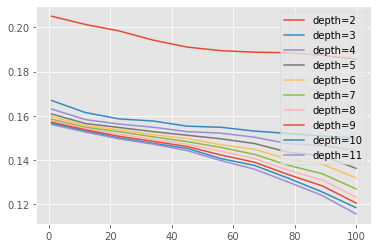

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

for i in range(scores.shape[0]):
    plt.plot(np.linspace(1, 100, 10), scores[i], label='depth=' + str(np.arange(2, 12)[i]))
plt.legend()

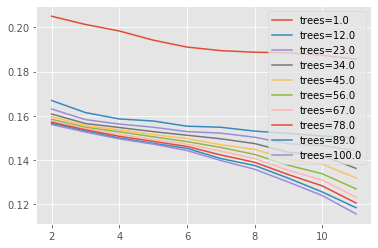

In [38]:
for i in range(scores.shape[1]):
    plt.plot(np.arange(2, 12), scores[i], label='trees=' + str(np.linspace(1, 100, 10)[i]))
plt.legend()

Сравним с лесом

In [39]:
%%time

from sklearn.ensemble import RandomForestRegressor

linear_preds = RandomForestRegressor(max_depth = 20, max_features = 13, min_samples_leaf = 1).fit(X_train, y_train).predict(X_test)
res5 = mean_squared_error(y_test, linear_preds) ** 0.5
print(res5)

0.3334589516124791
Wall time: 29.6 s


Итог: случайный лес отработал хуже градиентного бустинга